In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from os.path import expanduser
import re
from nltk.stem.porter import PorterStemmer

In [2]:
stop_words = [word.strip() for word in open('stop_words.txt').readlines()]

In [3]:
len(stop_words)


572

In [4]:
def stemming_tokenizer(str_input):
    porter_stemmer = PorterStemmer()
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [5]:
with open('dems.txt', 'r',encoding="utf-8") as file:
    dem_text = [line.strip('\n') for line in file]
with open('gop.txt', 'r',encoding="utf-8") as file:
    gop_text = [line.strip('\n') for line in file]
with open('NonPolitical.txt', 'r',encoding="utf-8") as file:
    nonp_text = [line.strip('\n') for line in file]

In [6]:
vectorizer = CountVectorizer(input=dem_text + gop_text+nonp_text,
                             stop_words=stop_words,
                             max_features=500,tokenizer=stemming_tokenizer)

In [7]:
dem_bow = vectorizer.fit_transform(dem_text)
gop_bow = vectorizer.fit_transform(gop_text)
nonp_bow = vectorizer.fit_transform(nonp_text)

In [8]:
#%%
(dem_bow.shape, gop_bow.shape, nonp_bow.shape)
#%%

((19373, 500), (18978, 500), (12913, 500))

In [9]:
x = sparse.vstack((dem_bow, gop_bow, nonp_bow))
ones = np.ones(19373)
zeros = np.zeros(18978)
twos = np.full(12913,2)
y = np.hstack((ones, zeros, twos))


In [10]:
class_names = ['Democrats','Republicans','Non-Political']

In [11]:
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
  

  
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(x, y,  test_size=0.25, random_state = 42) 
  
# training a DescisionTreeClassifier 
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 4).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
  
from sklearn.metrics import accuracy_score
print("Accuracy :")
accuracy_score(y_test, dtree_predictions)    

Accuracy :


0.8585362047440699

In [12]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(dtree_model, x, y, cv=5)
mn = np.mean(cv_scores)
print("cv_scores mean:{}")
print(format(mn))

cv_scores mean:{}
0.8576782509798242


In [13]:
#PLotting confusion matrix for decision tree classification
import matplotlib.pyplot as plt

from sklearn.metrics import plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(dtree_model, X_test, y_test,display_labels=class_names, cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix, without normalization
[[3211 1477   12]
 [  53 4767   19]
 [   1  251 3025]]
Normalized confusion matrix
[[6.83191489e-01 3.14255319e-01 2.55319149e-03]
 [1.09526762e-02 9.85120893e-01 3.92643108e-03]
 [3.05157156e-04 7.65944461e-02 9.23100397e-01]]


<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

In [14]:
y_test1 = np.zeros([len(y_test),3], int)
for i in range(0,len(y_test)):
        y_test1[i, int(y_test[i])] =1
        
y_score = np.zeros([len(y_test),3], int)
for i in range(0,len(dtree_predictions)):
        y_score[i, int(dtree_predictions[i])] =1

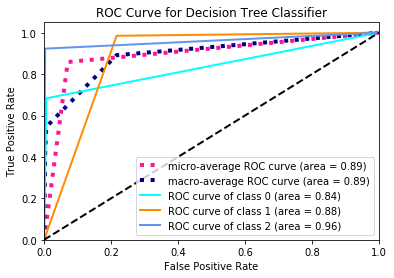

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw=2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()

[Text(326.874363302159, 217.16955223880598, 'X[117] <= 0.5\ngini = 0.656\nsamples = 38448\nvalue = [14278, 14534, 9636]'),
 Text(320.4975191395442, 216.6286567164179, 'X[77] <= 0.5\ngini = 0.525\nsamples = 29376\nvalue = [14212, 14410, 754]'),
 Text(314.2175000095306, 216.08776119402984, 'X[74] <= 0.5\ngini = 0.452\nsamples = 20756\nvalue = [5778, 14224, 754]'),
 Text(308.41046196648205, 215.5468656716418, 'X[358] <= 0.5\ngini = 0.554\nsamples = 12650\nvalue = [5723, 6173, 754]'),
 Text(303.6703855141777, 215.00597014925373, 'X[24] <= 0.5\ngini = 0.547\nsamples = 11183\nvalue = [4283, 6147, 753]'),
 Text(298.4926300172745, 214.46507462686566, 'X[115] <= 0.5\ngini = 0.538\nsamples = 10592\nvalue = [3721, 6118, 753]'),
 Text(294.20190611931554, 213.92417910447762, 'X[458] <= 0.5\ngini = 0.528\nsamples = 10153\nvalue = [3309, 6095, 749]'),
 Text(288.1251462514586, 213.38328358208955, 'X[330] <= 0.5\ngini = 0.549\nsamples = 9208\nvalue = [3257, 5204, 747]'),
 Text(284.6877824653424, 212.84

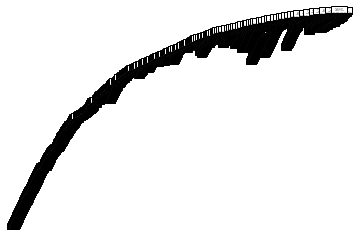

In [18]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train, y_train)
tree.plot_tree(clf)
